In [1]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import col

spark = SparkSession.builder.appName("mbd-prj").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/01/06 21:22:34 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/01/06 21:22:35 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [15]:
from pyspark.sql.functions import col, count, countDistinct, when, concat
from matplotlib import pyplot as plt
import numpy as np

# Reading the datasets

In [2]:
from pathlib import Path
lymsys_folder = Path("/Users/lgk1910/Library/CloudStorage/OneDrive-AaltoUniversity/Learning2/Big Data/Project/data/lmsys-chat-1m")
wildchat_folder = Path("/Users/lgk1910/Library/CloudStorage/OneDrive-AaltoUniversity/Learning2/Big Data/Project/data/WildChat-1M-Full/WildChat-1M-Full/")

In [97]:
# test reading the dataset from a folder of parquet files
lymsys_df = spark.read.parquet(str(lymsys_folder))
lymsys_df.show(5)
wildchat_df = spark.read.parquet(str(wildchat_folder))
wildchat_df.show(5)


+--------------------+----------+-----------------------------------+----+----------+--------------------+--------+
|     conversation_id|     model|                       conversation|turn|  language|   openai_moderation|redacted|
+--------------------+----------+-----------------------------------+----+----------+--------------------+--------+
|c20948192699451b8...|vicuna-13b|               [{Given the artic...|   1|   English|[{{false, false, ...|    true|
|8b02aa2df44847a1b...|vicuna-33b|               [{Alright, let's ...|   2|   English|[{{false, false, ...|    true|
|c18f3612fac140cb9...|vicuna-13b|[{あなたが最終更新されたのはいつ...|   5|  Japanese|[{{false, false, ...|   false|
|d1fabb62e3364665a...| llama-13b|               [{You are an AI a...|   1|   English|[{{false, false, ...|    true|
|b2da335248f04e439...| koala-13b|               [{Reescreva esse ...|   1|Portuguese|[{{false, false, ...|   false|
+--------------------+----------+-----------------------------------+----+----------+--

In [4]:
# number of rows in each dataset
print(lymsys_df.count())
print(wildchat_df.count())

1000000
990372


In [5]:
lymsys_first_10_pd = lymsys_df.limit(10).toPandas()
wild_first_10_pd = wildchat_df.limit(10).toPandas()

# Sample codes

In [6]:
# get the first row that whoses conversation size is greater than 2
lym_first_mul_conv = [lymsys_df.filter(F.size(col("conversation")) > 2).first()]
wild_first_mul_conv = [wildchat_df.filter(F.size(col("conversation")) > 2).first()]

In [7]:
# collect all header.user_agent from users, only take first 10
z = wildchat_df.select("hashed_ip", "header.accept-language", "header.user-agent").distinct().sort("hashed_ip").limit(100)
# count group by hashed_ip, filter by count > 1, take first 10
y = z.groupBy("hashed_ip").count().sort("hashed_ip").filter(col("count") > 1).limit(100).collect()
# filter out from z hashed_ip == '000d7b547ba8018da6976b037058a96b71d4ea9832d3ce40f9b35936987c60ef'
z = wildchat_df.filter(col("hashed_ip") == '0016ccd60404d131a67b492642c677287c7299fb0139945a3270b14f2b66921f').collect()

In [8]:
print(wildchat_df.groupBy("hashed_ip").count().filter(col("count") > 1).count())
print(wildchat_df.groupBy("hashed_ip").count().count())


84547


188517


In [9]:
# take the column 'conversation' from the first row of the dataframe, convert it to a list
lym_conv_sample = lymsys_df.select('conversation').first().conversation
print(lym_conv_sample[0].asDict().keys())
wild_conv_sample = wildchat_df.select('conversation').first().conversation
print(wild_conv_sample[0].asDict().keys())

dict_keys(['content', 'role'])
dict_keys(['content', 'country', 'hashed_ip', 'header', 'language', 'redacted', 'role', 'state', 'timestamp', 'toxic', 'turn_identifier'])


In [10]:
wildchat_df.select('header').first().header


Row(accept-language='en-US,en;q=0.9', user-agent='Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/116.0.0.0 Safari/537.36')

In [11]:
wildchat_df.filter(wildchat_df.header['user-agent'] == 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/116.0.0.0 Safari/537.36').count()


28341

In [12]:
wild_user_count = wildchat_df.groupBy('hashed_ip', 'header.accept-language').count()
print(f'{wild_user_count.count() = }')

wild_user_count.count() = 213440


In [13]:
# search all rows with hashed_ip = 'f96c8515aa663db23ee086f36b7d3642036d5394bbbeada3fe0c6c8285f4d314'
wild_ip = 'f96c8515aa663db23ee086f36b7d3642036d5394bbbeada3fe0c6c8285f4d314'
wild_ip_df = wildchat_df.filter(col('hashed_ip') == wild_ip)
wild_ip_df.show(5)


+--------------------+------------------+-------------------+--------------------+----+--------+--------------------+--------------------+-----+--------+--------+-------------+--------------------+--------------------+
|   conversation_hash|             model|          timestamp|        conversation|turn|language|   openai_moderation| detoxify_moderation|toxic|redacted|   state|      country|           hashed_ip|              header|
+--------------------+------------------+-------------------+--------------------+----+--------+--------------------+--------------------+-----+--------+--------+-------------+--------------------+--------------------+
|f01a345e668b978b6...|gpt-3.5-turbo-0613|2023-09-13 04:14:27|[{(In the clubroo...|   1| English|[{{false, false, ...|[{2.1957975695841...|false|   false|Michigan|United States|f96c8515aa663db23...|{en-US,en;q=0.9, ...|
|136971e6080d62e86...|gpt-3.5-turbo-0613|2023-09-13 09:40:52|[{(In the clubroo...|   1| English|[{{false, false, ...|[{2.195

In [14]:
# count number of unique conversation_id in lymsys_df
lym_conv_count = lymsys_df.select('conversation_id').distinct().count()
print(lym_conv_count)
# number of rows
lym_row_count = lymsys_df.count()
print(lym_row_count)

1000000
1000000


# Question 1: What percentage of users have multiple conversations?
- WildChat: Use combination of `hashed_ip` and `header` to estimate number of repeat users

In [16]:
# count number of users, group by hashed_ip and header.user-agent
wild_user_count = wildchat_df.groupBy('hashed_ip', 'header.user-agent').count()
print(f'{wild_user_count.count() = }')
# count number of users, group by hashed_ip only
wild_user_count = wildchat_df.groupBy('hashed_ip').count()
print(f'{wild_user_count.count() = }')


wild_user_count.count() = 241796
wild_user_count.count() = 188517


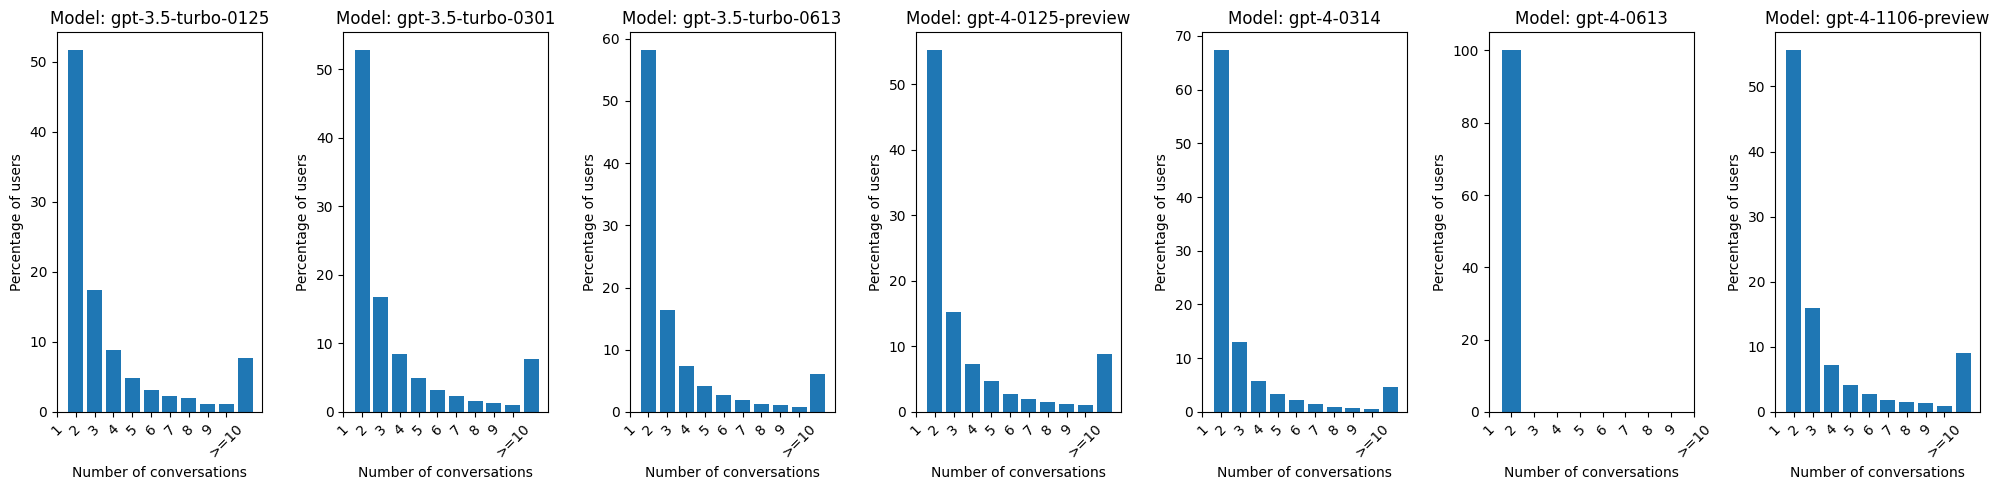

                 model  conversation_count  user_count  percentage
0   gpt-3.5-turbo-0125                   1        7024   51.628078
1   gpt-3.5-turbo-0125                   2        2371   17.427416
2   gpt-3.5-turbo-0125                   3        1201    8.827637
3   gpt-3.5-turbo-0125                   4         653    4.799706
4   gpt-3.5-turbo-0125                   5         426    3.131202
..                 ...                 ...         ...         ...
56  gpt-4-1106-preview                   6         383    1.859043
57  gpt-4-1106-preview                   7         302    1.465877
58  gpt-4-1106-preview                   8         270    1.310552
59  gpt-4-1106-preview                   9         183    0.888263
60  gpt-4-1106-preview                  10        1862    9.037957

[61 rows x 4 columns]


In [17]:
# Group by model and count conversations per user
# model_user_counts = wildchat_df.groupBy("composite_key", "model").count()
model_user_counts = wildchat_df.groupBy("hashed_ip", "model").count()

# Create distribution per model 
model_conversation_counts = model_user_counts.groupBy("model", "count")\
	.agg(F.count("*").alias("user_count"))\
	.orderBy("model", "count")

# Group counts >= 10 together
model_conversation_counts = model_conversation_counts.withColumn(
	"conversation_count",
	when(col("count") < 10, col("count")).otherwise(10)
)

# Aggregate after grouping
model_conversation_counts = model_conversation_counts.groupBy("model", "conversation_count")\
	.agg(F.sum("user_count").alias("user_count"))\
	.orderBy("model", "conversation_count")

# Convert to pandas for easier plotting
model_df = model_conversation_counts.toPandas()

# Calculate percentages per model
model_df['percentage'] = model_df.groupby('model')['user_count'].transform(
	lambda x: (x / x.sum()) * 100
)

# Create subplots for each model
models = model_df['model'].unique()
fig, axes = plt.subplots(1, len(models), figsize=(20, 5))

for i, model in enumerate(models):
	model_data = model_df[model_df['model'] == model]
	axes[i].bar(model_data['conversation_count'], model_data['percentage'])
	axes[i].set_title(f'Model: {model}')
	axes[i].set_xlabel('Number of conversations')
	axes[i].set_ylabel('Percentage of users')
	axes[i].set_xticks(range(10))
	axes[i].set_xticklabels([str(i) for i in range(1, 10)] + ['>=10'], rotation=45)

plt.tight_layout()
plt.show()
print(model_df)

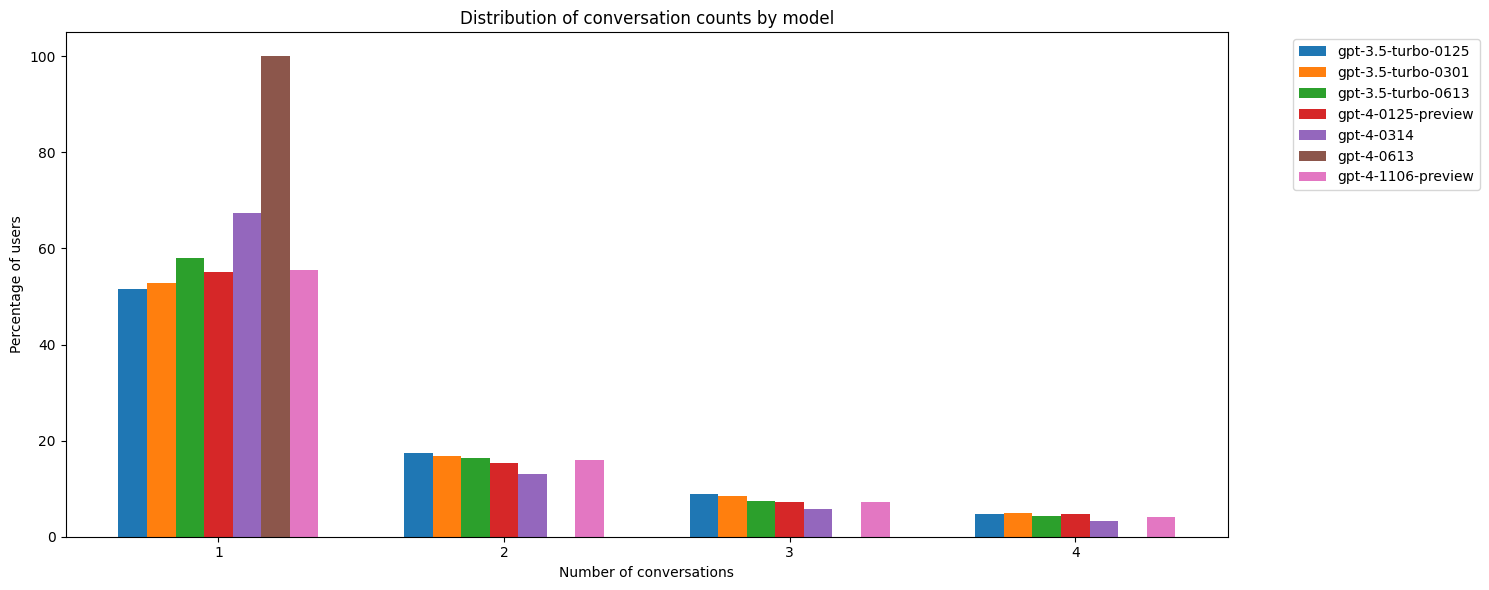

In [18]:
# Create a bar plot for conversation counts 1-4 across all models
conv_counts = [1, 2, 3, 4]
width = 0.1
x = np.arange(len(conv_counts))

plt.figure(figsize=(15, 6))

for i, model in enumerate(models):
	model_data = model_df[model_df['model'] == model]
	# Get only the rows with conversation_count in conv_counts
	model_data = model_data[model_data['conversation_count'].isin(conv_counts)]
	# Some models might not have all conversation counts, so we need to handle missing values
	percentages = []
	for conv_count in conv_counts:
		matching_row = model_data[model_data['conversation_count'] == conv_count]
		if len(matching_row) > 0:
			percentages.append(matching_row.iloc[0]['percentage'])
		else:
			percentages.append(0)
	
	plt.bar(x + i*width, percentages, width, label=model)

plt.xlabel('Number of conversations')
plt.ylabel('Percentage of users')
plt.title('Distribution of conversation counts by model')
plt.xticks(x + (len(models)-1)*width/2, conv_counts)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

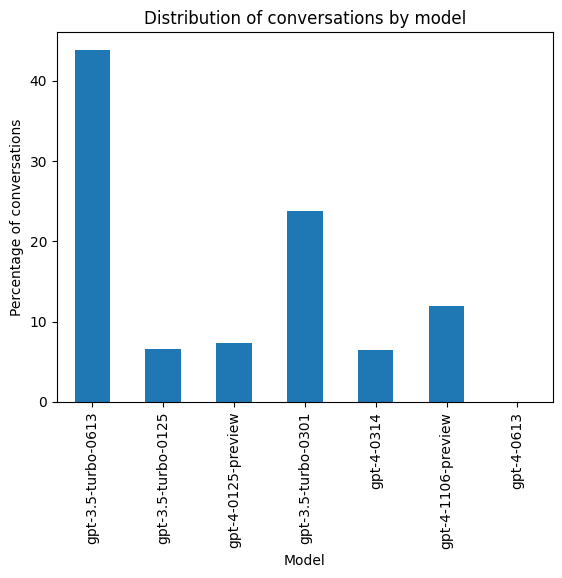

In [19]:
# Create a bar plot comparing all models and their number of conversations
# group by model
model_conversation_counts = wildchat_df.groupBy("model").count()
# convert them into percentages
model_conversation_counts = model_conversation_counts.withColumn(
	"percentage",
	(col("count") / wildchat_df.count()) * 100
)
# plot bar plot
model_conversation_counts.toPandas().plot.bar(x="model", y="percentage", legend=False)
plt.xlabel("Model")
plt.ylabel("Percentage of conversations")
plt.title("Distribution of conversations by model")
plt.show()


+------------+------+------------------+
|model_family| count|        percentage|
+------------+------+------------------+
|     GPT-3.5|735709| 74.28612682911067|
|       GPT-4|254663|25.713873170889322|
+------------+------+------------------+

None


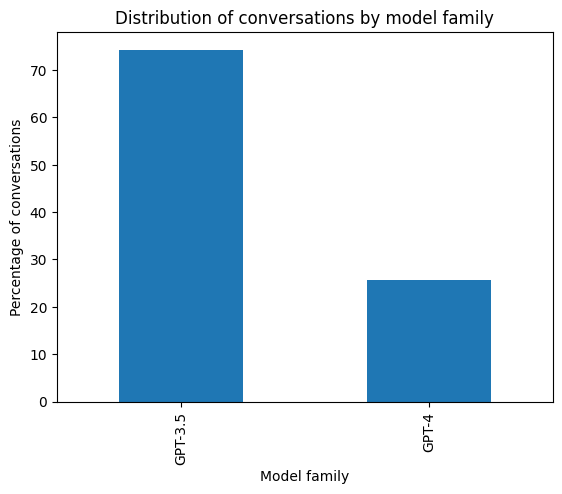

In [20]:
# Create a new column 'model_family' based on the model name
wildchat_df = wildchat_df.withColumn(
	"model_family",
	F.when(F.col("model").like("gpt-3.5%"), "GPT-3.5")
	 .when(F.col("model").like("gpt-4%"), "GPT-4")
	 .otherwise("Other")
)

# Group by model family and count conversations
model_family_counts = wildchat_df.groupBy("model_family").count()
# convert to percentages
model_family_counts = model_family_counts.withColumn(
	"percentage",
	(col("count") / wildchat_df.count()) * 100
)
print(model_family_counts.show())

# Convert to pandas for plotting
model_family_counts_pd = model_family_counts.toPandas()
model_family_counts_pd.plot.bar(x="model_family", y="percentage", legend=False)
plt.xlabel("Model family")
plt.ylabel("Percentage of conversations")
plt.title("Distribution of conversations by model family")
plt.show()


                model  avg_turns
0  gpt-3.5-turbo-0613   2.157038
1  gpt-3.5-turbo-0125   1.817120
2  gpt-4-0125-preview   3.216763
3  gpt-3.5-turbo-0301   3.121775
4          gpt-4-0314   1.888456
5  gpt-4-1106-preview   3.040836
6          gpt-4-0613   1.500000


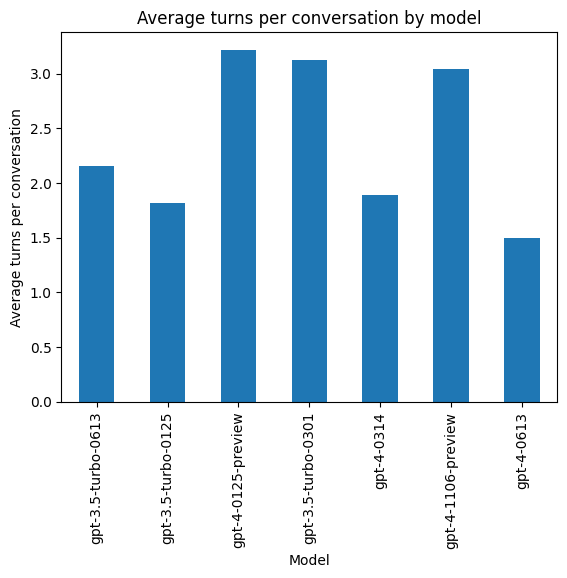

  model_family  avg_turns
0      GPT-3.5   2.435805
1        GPT-4   2.801235


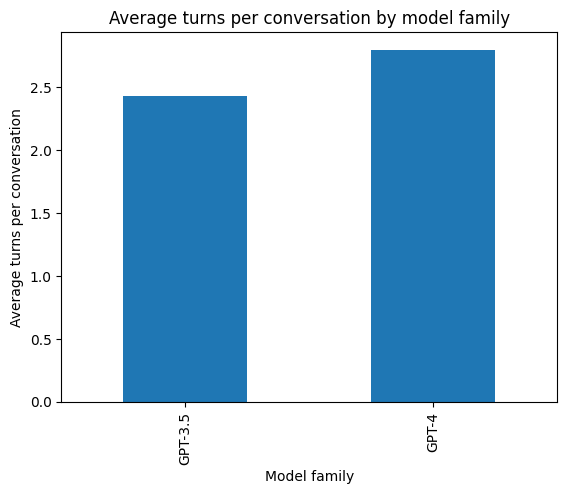

In [21]:
# Construct a bar graph to see the percentage of avg turns per conversation for each model, there's a column called `turn` in the dataset
avg_turns = wildchat_df.groupBy("model").agg(F.avg("turn").alias("avg_turns"))
avg_turns_pd = avg_turns.toPandas()
print(avg_turns_pd)
avg_turns_pd.plot.bar(x="model", y="avg_turns", legend=False)
plt.xlabel("Model")
plt.ylabel("Average turns per conversation")
plt.title("Average turns per conversation by model")
plt.show()

# Now, instead of grouping by model, group by model_family
avg_turns = wildchat_df.groupBy("model_family").agg(F.avg("turn").alias("avg_turns"))
avg_turns_pd = avg_turns.toPandas()
print(avg_turns_pd)
avg_turns_pd.plot.bar(x="model_family", y="avg_turns", legend=False)
plt.xlabel("Model family")
plt.ylabel("Average turns per conversation")
plt.title("Average turns per conversation by model family")
plt.show()


+------------+----+------+------------------+
|model_family|turn| count|        percentage|
+------------+----+------+------------------+
|     GPT-3.5|   1|439457| 59.73244856322268|
|     GPT-3.5|   9|  7310|0.9935993714906302|
|     GPT-3.5|   5| 24799| 3.370762081203302|
|     GPT-3.5|   4| 37003|  5.02957011535811|
|     GPT-3.5|   6| 17827| 2.423104787354783|
|     GPT-3.5|   7| 12942|1.7591194344503058|
|     GPT-3.5|   3| 58326| 7.927862782703487|
|     GPT-3.5|   8|  9642|1.3105725225598708|
|     GPT-3.5|   2|103716| 14.09742167079647|
|     GPT-3.5|  10| 24687|3.3555386708603536|
|       GPT-4|   4| 11941| 4.688941856492698|
|       GPT-4|   7|  4041| 1.586802951351394|
|       GPT-4|   9|  2366|0.9290709682992818|
|       GPT-4|   6|  5614|2.2044820017042133|
|       GPT-4|   2| 38804|15.237392161405467|
|       GPT-4|  10| 12649| 4.966956330523083|
|       GPT-4|   5|  7725| 3.033420638255263|
|       GPT-4|   1|148833| 58.44311894542984|
|       GPT-4|   3| 19571|7.685058

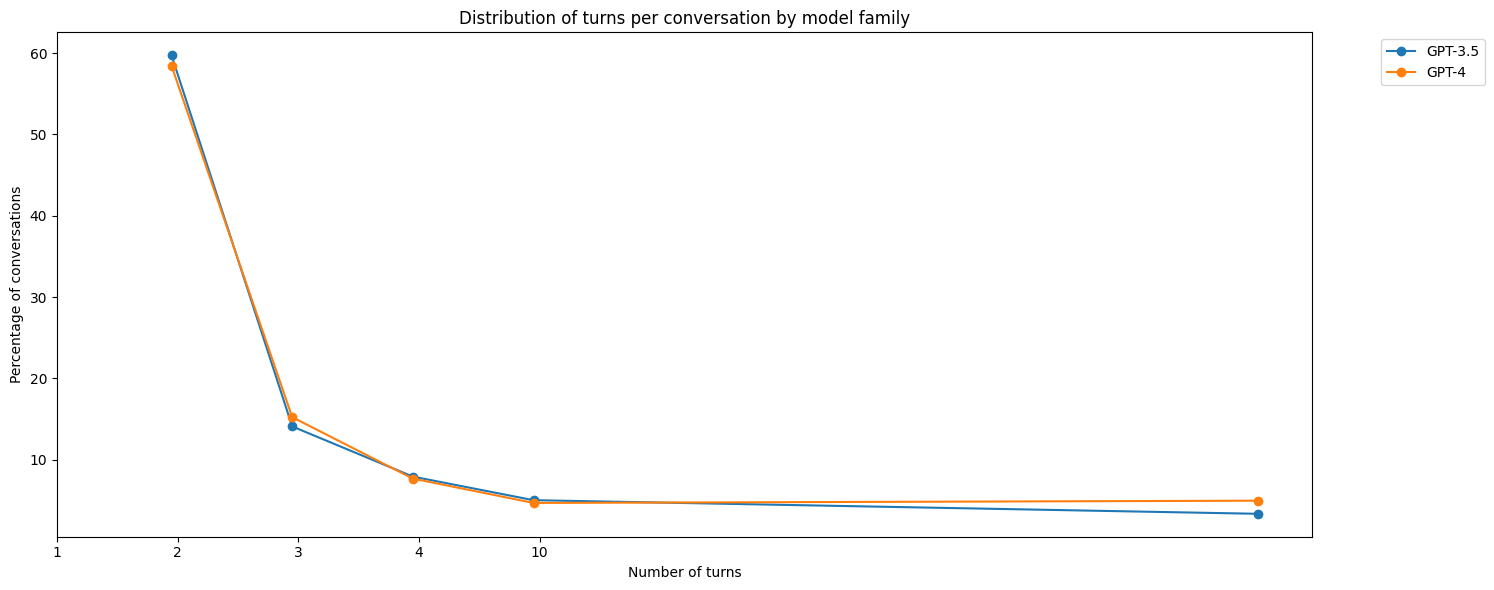

In [22]:
# Now, group by model_family and turn, and count the number of conversations
# map turn >= 10 to 10
turn_counts = wildchat_df.withColumn(
	"turn",
	when(col("turn") < 10, col("turn")).otherwise(10)
)
turn_counts = turn_counts.groupBy("model_family", "turn").count()

# convert to percentages per model family
# count total number of types of turns per model family
total_turns = turn_counts.groupBy("model_family").agg(F.sum("count").alias("total_turns"))
# join total_turns with turn_counts
turn_counts = turn_counts.join(total_turns, "model_family")
# calculate percentage
turn_counts = turn_counts.withColumn(
	"percentage",
	(col("count") / col("total_turns")) * 100
)
# drop total_turns column
turn_counts = turn_counts.drop("total_turns")
# show the results
print(turn_counts.show())

# Plot the distribution of turns per conversation by model family, for each value of turn, plot the models side by side
# Create a bar plot for turn counts 1-4 across all models
turns = [1, 2, 3, 4, 10]
width = 0.1
x = np.arange(len(turns))

plt.figure(figsize=(15, 6))
model_families = turn_counts.select("model_family").distinct().rdd.flatMap(lambda x: x).collect()

turn_counts = turn_counts.toPandas()
for i, model_family in enumerate(model_families):
	model_data = turn_counts[turn_counts['model_family'] == model_family]
	# Get only the rows with turn in turns
	model_data = model_data[model_data['turn'].isin(turns)]
	# Some models might not have all turns, so we need to handle missing values
	percentages = []
	for turn in turns:
		matching_row = model_data[model_data['turn'] == turn]
		if len(matching_row) > 0:
			percentages.append(matching_row.iloc[0]['percentage'])
		else:
			percentages.append(0)

	plt.plot(turns, percentages, marker='o', label=model_family)

plt.xlabel('Number of turns')
plt.ylabel('Percentage of conversations')
plt.title('Distribution of turns per conversation by model family')
plt.xticks(x + (len(model_families)-1)*width/2, turns)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

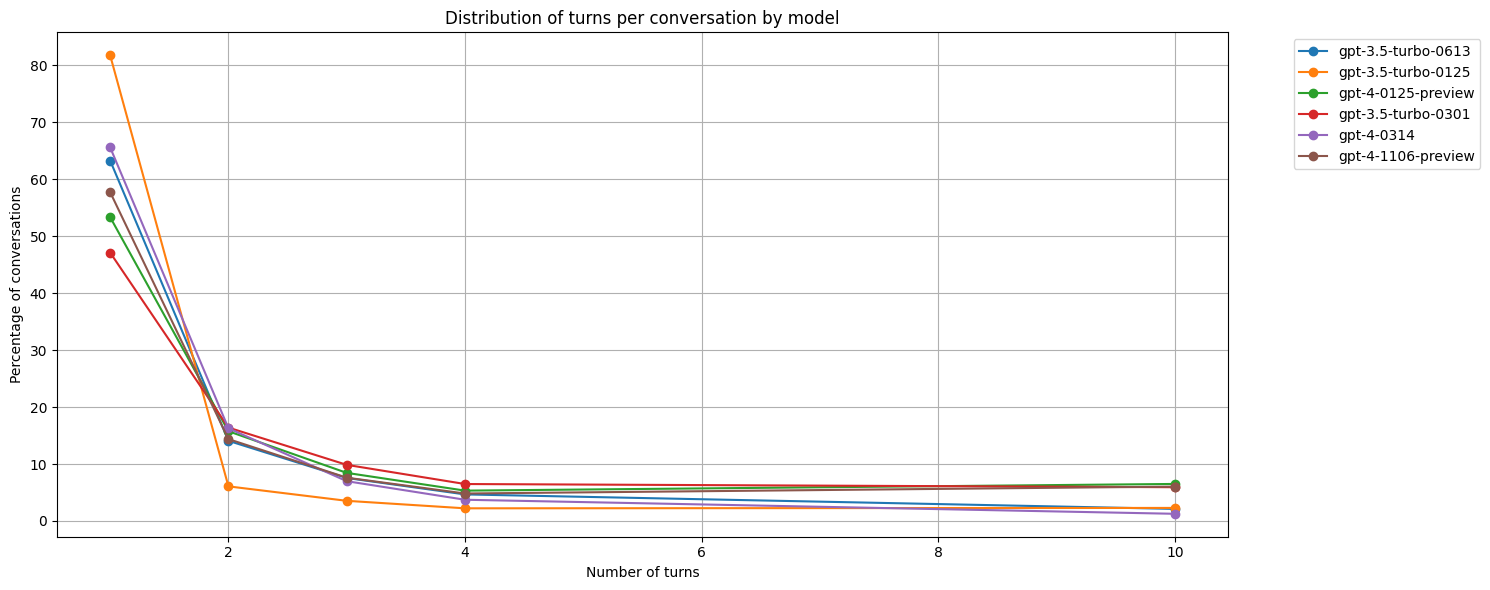

In [23]:
# Now, group by model and turn, and count the number of conversations
# map turn >= 10 to 10
turn_counts = wildchat_df.withColumn(
	"turn",
	when(col("turn") < 10, col("turn")).otherwise(10)
)
turn_counts = turn_counts.groupBy("model", "turn").count()

# convert to percentages per model
# count total number of types of turns per model
total_turns = turn_counts.groupBy("model").agg(F.sum("count").alias("total_turns"))
# join total_turns with turn_counts
turn_counts = turn_counts.join(total_turns, "model")
# calculate percentage
turn_counts = turn_counts.withColumn(
	"percentage",
	(col("count") / col("total_turns")) * 100
)
# drop total_turns column
turn_counts = turn_counts.drop("total_turns")

# Plot the distribution of turns per conversation by model for turns 1-4
turns = [1, 2, 3, 4, 10]
width = 0.1
x = np.arange(len(turns))

plt.figure(figsize=(15, 6))
models = wildchat_df.select("model").distinct().rdd.flatMap(lambda x: x).collect()
# ommit the model gpt-4-0613
models.remove('gpt-4-0613')

turn_counts = turn_counts.toPandas()
for i, model in enumerate(models):
	model_data = turn_counts[turn_counts['model'] == model]
	# Get only the rows with turn in turns
	model_data = model_data[model_data['turn'].isin(turns)]
	# Some models might not have all turns, so we need to handle missing values
	percentages = []
	for turn in turns:
		matching_row = model_data[model_data['turn'] == turn]
		if len(matching_row) > 0:
			percentages.append(matching_row.iloc[0]['percentage'])
		else:
			percentages.append(0)

	plt.plot(turns, percentages, marker='o', label=model)

plt.xlabel('Number of turns')
plt.ylabel('Percentage of conversations')
plt.title('Distribution of turns per conversation by model')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# Question 2: What is the distribution of conversations per user?
- WildChat: For IP addresses with multiple conversations, plot histogram of conversation counts

In [24]:
# 1. Create analysis on composite_key (already created in cell 14)
wildchat_df = wildchat_df.withColumn(
    "composite_key",
    concat(col("hashed_ip"), F.lit("_"), col("header.user-agent"))
)

# 2. Count conversations per unique user
# user_conversation_counts = wildchat_df.groupBy("composite_key").agg(
# 	count("conversation_hash").alias("conversation_count")
# )
user_conversation_counts = wildchat_df.groupBy("hashed_ip").agg(
	count("conversation_hash").alias("conversation_count")
)

# 3. Calculate statistics
total_users = user_conversation_counts.count()
repeat_users = user_conversation_counts.filter(col("conversation_count") > 1).count()
repeat_percentage = (repeat_users / total_users) * 100

# 4. Show results
print(f"Total unique users: {total_users}")
print(f"Users with multiple conversations: {repeat_users}")
print(f"Percentage of repeat users: {repeat_percentage:.2f}%")


Total unique users: 188517
Users with multiple conversations: 84547
Percentage of repeat users: 44.85%


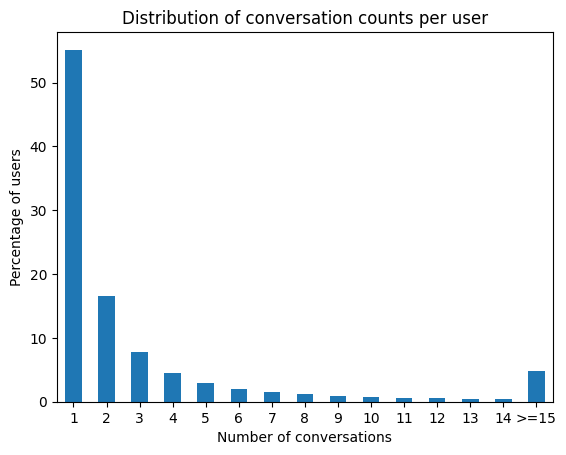

    conversation_count  user_count  percentage
0                    1      103970   55.151525
1                    2       31189   16.544397
2                    3       14582    7.735111
3                    4        8353    4.430900
4                    5        5517    2.926527
5                    6        3868    2.051804
6                    7        2809    1.490051
7                    8        2214    1.174430
8                    9        1735    0.920341
9                   10        1430    0.758552
10                  11        1215    0.644504
11                  12         997    0.528865
12                  13         833    0.441870
13                  14         743    0.394129
14                  15        9062    4.806994


In [25]:
# 5. Optional: Distribution of conversation counts
user_conversation_counts_grouped = user_conversation_counts.groupBy("conversation_count") \
	.agg(count("*").alias("user_count")) \
	.orderBy("conversation_count") \

# 5.1. Group into bins
max_count_cutoff = 15
user_conversation_counts_grouped = user_conversation_counts_grouped.withColumn(
	"conversation_count",
	when(col("conversation_count") < max_count_cutoff, col("conversation_count")).otherwise(max_count_cutoff)
)
user_conversation_counts_grouped = user_conversation_counts_grouped.groupBy("conversation_count") \
	.agg(F.sum("user_count").alias("user_count")) \
	.orderBy("conversation_count")

# 6. Plot distribution, plot in % scale
# Calculate total users for percentage
total = user_conversation_counts_grouped.agg(F.sum("user_count")).collect()[0][0]
# Convert to pandas and calculate percentage
df_plot = user_conversation_counts_grouped.toPandas()
df_plot['percentage'] = (df_plot['user_count'] / total) * 100
# Create the plot
df_plot.plot.bar(x="conversation_count", y="percentage", legend=False)
plt.xticks(range(max_count_cutoff), [str(i) for i in range(1, max_count_cutoff)] + [f'>={max_count_cutoff}'], rotation=0)  # Changed this line
plt.xlabel("Number of conversations")
plt.ylabel("Percentage of users")
plt.title("Distribution of conversation counts per user")
plt.show()
print(df_plot)

# Question 3: Does frequency of user engagement correlate with conversation length?
- WildChat: Compare avg turns per sample for one-time vs repeat users

* Note: we define repeat users as user who have more than 3 conversations

In [26]:
user_counts = wildchat_df.groupBy("hashed_ip").agg(F.count("*").alias("conv_count"))

# Create a binary column for repeat users or not (count > 3)
user_counts = user_counts.withColumn(
	"repeat_user",
	F.when(F.col("conv_count") > 3, 1).otherwise(0)
)

# Count, group by turn and repeat_user
turn_counts = user_counts.groupBy("repeat_user", "conv_count").count()
# Create df of repeat users and non-repeat users
repeat_users = turn_counts.filter(F.col("repeat_user") == 1)
non_repeat_users = turn_counts.filter(F.col("repeat_user") == 0)

# Count, group by turn on each df
repeat_turn_counts = repeat_users.groupBy("conv_count").agg(F.sum("count").alias("count")).orderBy("conv_count")
non_repeat_turn_counts = non_repeat_users.groupBy("conv_count").agg(F.sum("count").alias("count")).orderBy("conv_count")

# Create a column that represents corresponding percentages
# First, calculate total count for each group
total_repeat = repeat_turn_counts.agg(F.sum("count")).collect()[0][0]
total_non_repeat = non_repeat_turn_counts.agg(F.sum("count")).collect()[0][0]
# Calculate percentages
repeat_turn_counts = repeat_turn_counts.withColumn("percentage", (F.col("count") / total_repeat) * 100)
non_repeat_turn_counts = non_repeat_turn_counts.withColumn("percentage", (F.col("count") / total_non_repeat) * 100)

repeat_turn_counts.show(5)
non_repeat_turn_counts.show(5)

+----------+-----+------------------+
|conv_count|count|        percentage|
+----------+-----+------------------+
|         4| 8353| 21.54167526304931|
|         5| 5517|14.227872911079018|
|         6| 3868|  9.97524241799051|
|         7| 2809|   7.2441716525686|
|         8| 2214| 5.709717350938725|
+----------+-----+------------------+
only showing top 5 rows

+----------+------+-----------------+
|conv_count| count|       percentage|
+----------+------+-----------------+
|         1|103970|69.43322136221877|
|         2| 31189|20.82863076912803|
|         3| 14582|9.738147868653208|
+----------+------+-----------------+



In [27]:
# Calculate avg turn per conversation for every user
avg_turns = wildchat_df.groupBy("hashed_ip").agg(F.avg("turn").alias("avg_turns"))

# Join the two dataframes
avg_turns = avg_turns.join(user_counts, "hashed_ip") # avg turns per user

# Calculate avg turn per conversation for repeat users and non-repeat users
avg_turns_repeat = avg_turns.filter(F.col("repeat_user") == 1).agg(F.avg("avg_turns")).collect()[0][0]
avg_turns_non_repeat = avg_turns.filter(F.col("repeat_user") == 0).agg(F.avg("avg_turns")).collect()[0][0]

print(f"Average turns per conversation for repeat users: {avg_turns_repeat:.2f}")
print(f"Average turns per conversation for non-repeat users: {avg_turns_non_repeat:.2f}")

# Calculate median turn per conversation for repeat users and non-repeat users
median_turns_repeat = avg_turns.filter(F.col("repeat_user") == 1).approxQuantile("avg_turns", [0.5], 0.001)[0]
median_turns_non_repeat = avg_turns.filter(F.col("repeat_user") == 0).approxQuantile("avg_turns", [0.5], 0.001)[0]

print(f"Median turns per conversation for repeat users: {median_turns_repeat:.2f}")
print(f"Median turns per conversation for non-repeat users: {median_turns_non_repeat:.2f}")


Average turns per conversation for repeat users: 2.86
Average turns per conversation for non-repeat users: 2.58


Median turns per conversation for repeat users: 2.22
Median turns per conversation for non-repeat users: 1.50


In [28]:
# Calculate the histogram of turns per conversation for repeat users and non-repeat users 
# Using deciles (10 bins) for more granular distribution
bin_threshold_repeat = avg_turns.filter(F.col("repeat_user") == 1).approxQuantile("avg_turns", 
	[i/10.0 for i in range(11)], # 0.0, 0.1, 0.2, ..., 1.0
	0.001)

bin_threshold_non_repeat = avg_turns.filter(F.col("repeat_user") == 0).approxQuantile("avg_turns",
	[i/10.0 for i in range(11)], # 0.0, 0.1, 0.2, ..., 1.0  
	0.001)

# Print the results
print("Bins for the histogram of turns per conversation for repeat users:")
print(bin_threshold_repeat)
print("Bins for the histogram of turns per conversation for non-repeat users:")
print(bin_threshold_non_repeat)

# Create a column to assign corresponding bin to each user
# Create a function to assign bins based on thresholds
def assign_bin_for_repeat(value, thresholds):
	for i in range(len(thresholds)-1):
		if value >= thresholds[i] and value < thresholds[i+1]:
			return i
	return len(thresholds)-2

def assign_bin_for_non_repeat(value, thresholds):
	for i in range(len(thresholds)-1):
		if value >= thresholds[i] and value < thresholds[i+1]:
			return i
	return len(thresholds)-2

# Create two separate DataFrames for repeat and non-repeat users
avg_turns_repeat = avg_turns.filter(F.col("repeat_user") == 1)
avg_turns_non_repeat = avg_turns.filter(F.col("repeat_user") == 0)

# Create UDFs for the bin assignment
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import udf

assign_bin_repeat_udf = udf(lambda x: assign_bin_for_repeat(x, bin_threshold_repeat), IntegerType())
assign_bin_non_repeat_udf = udf(lambda x: assign_bin_for_non_repeat(x, bin_threshold_non_repeat), IntegerType())

# Assign bins to each user
avg_turns_repeat = avg_turns_repeat.withColumn("bin", assign_bin_repeat_udf(F.col("avg_turns")))
avg_turns_non_repeat = avg_turns_non_repeat.withColumn("bin", assign_bin_non_repeat_udf(F.col("avg_turns")))
avg_turns_repeat.show(5)
avg_turns_non_repeat.show(5)

# Group by bin and count the number of users
repeat_bin_counts = avg_turns_repeat.groupBy("bin").count().orderBy("bin")
non_repeat_bin_counts = avg_turns_non_repeat.groupBy("bin").count().orderBy("bin")

# Calculate total users for percentage
total_repeat = avg_turns_repeat.count()
total_non_repeat = avg_turns_non_repeat.count()

# Calculate percentages
repeat_bin_counts = repeat_bin_counts.withColumn("percentage", (F.col("count") / total_repeat) * 100)
non_repeat_bin_counts = non_repeat_bin_counts.withColumn("percentage", (F.col("count") / total_non_repeat) * 100)

repeat_bin_counts.show(5)
non_repeat_bin_counts.show(5)

Bins for the histogram of turns per conversation for repeat users:
[1.0, 1.0, 1.1428571428571428, 1.5, 1.8181818181818181, 2.2222222222222223, 2.6666666666666665, 3.2, 4.0, 5.30188679245283, 56.6]
Bins for the histogram of turns per conversation for non-repeat users:
[1.0, 1.0, 1.0, 1.0, 1.0, 1.5, 2.0, 2.5, 3.5, 5.0, 132.0]


+--------------------+------------------+----------+-----------+---+
|           hashed_ip|         avg_turns|conv_count|repeat_user|bin|
+--------------------+------------------+----------+-----------+---+
|00073b9ff305f8693...|1.1666666666666667|         6|          1|  2|
|000aa94bb8c8c7868...|               2.6|         5|          1|  5|
|000f22bb6abf4e96e...|               1.0|         6|          1|  1|
|00130c75d1bb6b7ed...|2.8333333333333335|         6|          1|  6|
|0016ccd60404d131a...|             1.625|         8|          1|  3|
+--------------------+------------------+----------+-----------+---+
only showing top 5 rows



+--------------------+---------+----------+-----------+---+
|           hashed_ip|avg_turns|conv_count|repeat_user|bin|
+--------------------+---------+----------+-----------+---+
|00068e0c2bd27cca7...|      4.0|         1|          0|  8|
|000e15c1a7503cf5e...|      1.0|         1|          0|  4|
|001100154879561ff...|      9.0|         1|          0|  9|
|0015339487d414417...|     10.0|         1|          0|  9|
|001b1d4f5ca117166...|      1.0|         1|          0|  4|
+--------------------+---------+----------+-----------+---+
only showing top 5 rows



+---+-----+------------------+
|bin|count|        percentage|
+---+-----+------------------+
|  1| 7711|19.886011966164638|
|  2| 3726| 9.609036517433465|
|  3| 4033|10.400763358778626|
|  4| 3836| 9.892717144625541|
|  5| 3831| 9.879822570662265|
+---+-----+------------------+
only showing top 5 rows



+---+-----+------------------+
|bin|count|        percentage|
+---+-----+------------------+
|  4|70288| 46.93971590947035|
|  5| 6261| 4.181219572461784|
|  6|25567|17.074148028929955|
|  7|17251|11.520558831582532|
|  8|11093|  7.40812469530723|
+---+-----+------------------+
only showing top 5 rows



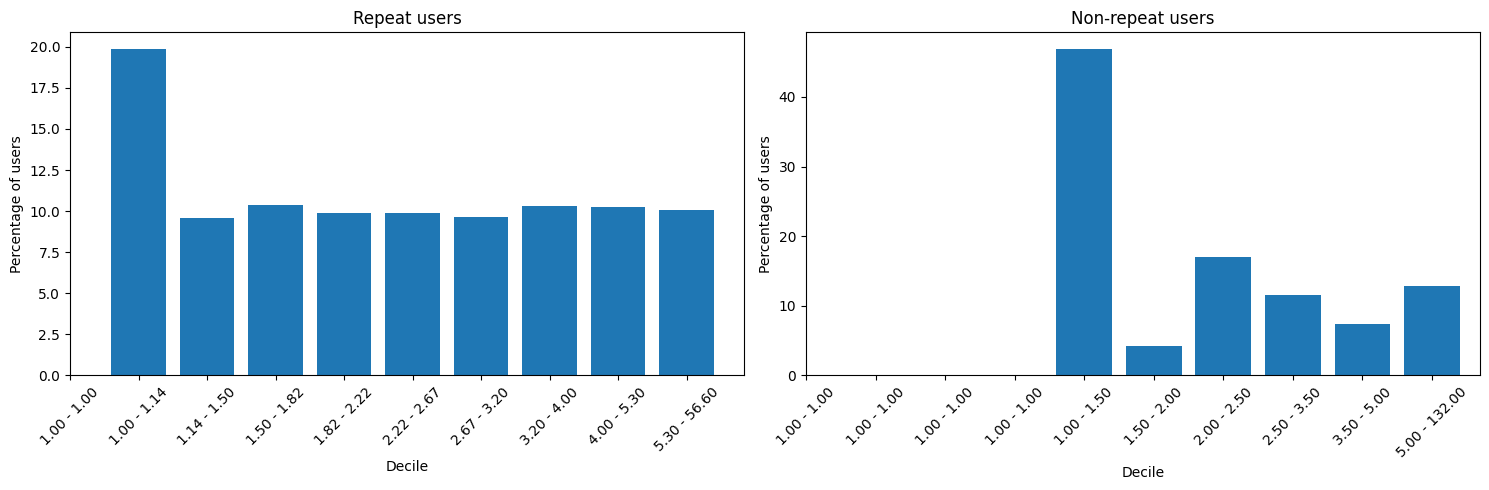

In [29]:
# Plot the histogram of turns per conversation for repeat users and non-repeat users
# Convert to pandas for plotting
repeat_bin_counts_pd = repeat_bin_counts.toPandas()
non_repeat_bin_counts_pd = non_repeat_bin_counts.toPandas()
# Create the plot
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].bar(repeat_bin_counts_pd["bin"], repeat_bin_counts_pd["percentage"])
axes[0].set_title("Repeat users")
axes[0].set_xlabel("Decile")
axes[0].set_ylabel("Percentage of users")
axes[0].set_xticks(range(10))
# set xticks, round to 2 decimal places
axes[0].set_xticklabels([f"{bin_threshold_repeat[int(i)]:.2f} - {bin_threshold_repeat[int(i+1)]:.2f}" for i in range(len(bin_threshold_repeat)) if i < len(bin_threshold_repeat) - 1], rotation=45)

axes[1].bar(non_repeat_bin_counts_pd["bin"], non_repeat_bin_counts_pd["percentage"])
axes[1].set_title("Non-repeat users")
axes[1].set_xlabel("Decile")
axes[1].set_ylabel("Percentage of users")
axes[1].set_xticks(range(10))
axes[1].set_xticklabels([f"{bin_threshold_non_repeat[int(i)]:.2f} - {bin_threshold_non_repeat[int(i+1)]:.2f}" for i in range(len(bin_threshold_non_repeat)) if i < len(bin_threshold_non_repeat) - 1], rotation=45)
plt.tight_layout()
plt.show()

# Question 4: What is the most common time gap between a user's conversations?
- WildChat: For repeat users, find median time between their conversation timestamps
- Lymsys: Use assistant turn timestamps to characterize typical response times
* Note: we define repeat users as user who have more than 3 conversations

In [16]:
from pyspark.sql import Window

In [17]:
user_counts = wildchat_df.groupBy("hashed_ip").agg(F.count("*").alias("conv_count"))

# Create a binary column for repeat users or not (count > 3)
user_counts = user_counts.withColumn(
	"repeat_user",
	F.when(F.col("conv_count") > 3, 1).otherwise(0)
)

# Calculate avg time gap between conversations for every user
# First, convert timestamp to unix timestamp

# Convert timestamp to unix timestamp
wildchat_df = wildchat_df.withColumn("timestamp_unix", F.unix_timestamp("timestamp"))

# Calculate time gap between conversations for each user
# First, sort by timestamp
window = Window.partitionBy("hashed_ip").orderBy("timestamp_unix")
wildchat_df = wildchat_df.withColumn("time_gap", F.col("timestamp_unix") - F.lag("timestamp_unix").over(window)) # time gap between conversations

In [18]:
# Calculate avg time gap per user
avg_time_gap = wildchat_df.groupBy("hashed_ip").agg(F.avg("time_gap").alias("avg_time_gap"))

# Join the two dataframes
avg_time_gap = avg_time_gap.join(user_counts, "hashed_ip") # avg time gap per user

# Calculate avg time gap between conversations for repeat users and non-repeat users
avg_time_gap_repeat = avg_time_gap.filter(F.col("repeat_user") == 1).agg(F.avg("avg_time_gap")).collect()[0][0]
avg_time_gap_non_repeat = avg_time_gap.filter(F.col("repeat_user") == 0).agg(F.avg("avg_time_gap")).collect()[0][0]
print(f"Average time gap between conversations for repeat users: {avg_time_gap_repeat/3600:.2f} hours")
print(f"Average time gap between conversations for non-repeat users: {avg_time_gap_non_repeat/3600:.2f} hours")


Average time gap between conversations for repeat users: 118.58 hours
Average time gap between conversations for non-repeat users: 178.64 hours


In [19]:
# Calculate median time gap per user
median_time_gap = wildchat_df.groupBy("hashed_ip").agg(F.expr("percentile_approx(time_gap, 0.5)").alias("median_time_gap"))

# Join the two dataframes
median_time_gap = median_time_gap.join(user_counts, "hashed_ip") # median time gap per user

# calculate median time gap between conversations for repeat users and non-repeat users
median_time_gap_repeat = median_time_gap.filter(F.col("repeat_user") == 1).approxQuantile("median_time_gap", [0.5], 0.001)[0]
median_time_gap_non_repeat = median_time_gap.filter(F.col("repeat_user") == 0).approxQuantile("median_time_gap", [0.5], 0.001)[0]

print(f"Median time gap between conversations for repeat users: {median_time_gap_repeat/3600:.2f} hours")
print(f"Median time gap between conversations for non-repeat users: {median_time_gap_non_repeat/3600:.2f} hours")

Median time gap between conversations for repeat users: 0.46 hours
Median time gap between conversations for non-repeat users: 0.34 hours


In [20]:
# Calculate avg time gap between conversations for repeat users and non-repeat users
avg_time_gap_repeat = median_time_gap.filter(F.col("repeat_user") == 1).agg(F.avg("median_time_gap")).collect()[0][0]
avg_time_gap_non_repeat = median_time_gap.filter(F.col("repeat_user") == 0).agg(F.avg("median_time_gap")).collect()[0][0]
print(f"Average time gap between conversations for repeat users: {avg_time_gap_repeat/3600:.2f} hours")
print(f"Average time gap between conversations for non-repeat users: {avg_time_gap_non_repeat/3600:.2f} hours")


Average time gap between conversations for repeat users: 32.12 hours
Average time gap between conversations for non-repeat users: 133.74 hours


**Discussion**: average time gap between conversations of repeated users are much smaller than non-repeat users, which is 32.12 hours and 133.74 hours respectively.

# Question 5: What are the peak conversation times for different regions?
- WildChat: Segment conversations by country/state and find top times for each
- Lymsys: Analyze timestamp distribution by language to infer regional patterns


In [16]:
!pip install timezonefinder geopy pytz


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [17]:
# Add a column of timezone based on country and state
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from geopy.geocoders import Photon
from timezonefinder import TimezoneFinder
from datetime import datetime
import pytz

# Initialize geolocator
geolocator = Photon(user_agent="geoapiExercises",timeout=10)



In [18]:
# Example timezone
timezone_name = 'America/New_York'  # Replace with your timezone

# Get the current time in the given timezone
local_timezone = pytz.timezone(timezone_name)
local_time = datetime.now(local_timezone)

# # Convert local time to GMT
# gmt_timezone = pytz.timezone('GMT')
# gmt_time = local_time.astimezone(gmt_timezone)

# print("Local Time:", local_time)
# print("GMT Time:", gmt_time)

In [ ]:
# # Create a function to map country and state to timezone
# def map_timezone(country, state):
# 	if state is None:
# 		location = geolocator.geocode(country)
# 	else:
# 		location = geolocator.geocode(f"{state}, {country}")
# 	if location is None:
# 		print(f"Location not found for {country}, {state}")
# 		print(f'Trying with country only: {country}')
# 		location = geolocator.geocode(country)
# 		if location is None:
# 			print(f"Location not found for {country}")
# 			return None
# 	latitude = location.latitude
# 	longitude = location.longitude
# 	tf = TimezoneFinder()
# 	timezone = tf.timezone_at(lng=longitude, lat=latitude)
# 	if timezone is None:
# 		print(f"Timezone not found for {country = }, {state = }")
# 		return None
# 	print(f"Timezone found for {country = }, {state = }: {timezone}")
# 	return timezone

# print(map_timezone("United States", "Michigan"))

# # Create a UDF
# map_timezone_udf = udf(map_timezone, StringType())

# # Add a column of timezone based on country and state
# country_state_df = wildchat_df.select("country", "state").distinct()
# # convert to pandas and apply the function
# country_state_df = country_state_df.toPandas()
# country_state_df["timezone"] = country_state_df.apply(lambda x: map_timezone(x["country"], x["state"]), axis=1)
# # show result
# print(country_state_df.head(5))
# # check if any timezone is null
# print('check if any timezone is null')
# print(country_state_df[country_state_df["timezone"].isnull()])
# print('------')

# # convert back to spark dataframe
# country_state_df = spark.createDataFrame(country_state_df)

# # join with wildchat_df
# wildchat_df = wildchat_df.join(country_state_df, ["country", "state"], "left")

# # Show the results where timezone is null
# wildchat_df.select("country", "state", "timezone").filter(F.col("timezone").isNull()).show(5)

In [ ]:
# # Save timezone mapping to a single parquet file
# country_state_df.coalesce(1).write.mode("overwrite").parquet("country_state_timezone.parquet")

In [80]:
wildchat_df.columns

['conversation_hash',
 'model',
 'timestamp',
 'conversation',
 'turn',
 'language',
 'openai_moderation',
 'detoxify_moderation',
 'toxic',
 'redacted',
 'state',
 'country',
 'hashed_ip',
 'header',
 'country',
 'state',
 'timezone']

In [93]:
# open the parquet file
country_state_df = spark.read.parquet("../country_state_timezone.parquet")
country_state_df.count() # 2433

2433

In [98]:
# join condition to handle cases when 'state' is null
wildchat_df = wildchat_df.join(
    country_state_df,
    (
        (wildchat_df["country"] == country_state_df["ccountry"]) &
        (
            (wildchat_df["state"] == country_state_df["sstate"]) |
            (wildchat_df["state"].isNull() & country_state_df["sstate"].isNull())
        )
    ),
    "left"
)


# Select the required columns and filter to show rows where 'timezone' is null
wildchat_df.select("country", "state", "timezone").filter(F.col("timezone").isNull()).count()

1262

In [83]:
# join condition to handle cases when 'state' is null
wildchat_df = wildchat_df.alias("w").join(
    country_state_df.alias("cs"),
    (
        (F.col("w.country") == F.col("cs.country")) &
        (
            (F.col("w.state") == F.col("cs.state")) |
            (F.col("w.state").isNull() & F.col("cs.state").isNull())
        )
    ),
    "left"
)

# Select all columns from wildchat_df and the timezone column from country_state_df
wildchat_df = wildchat_df.select(
    "w.*",  # All columns from wildchat_df
    F.col("cs.timezone").alias("timezone")  # Timezone column from country_state_df
)

# Show rows where 'timezone' is null
wildchat_df.filter(F.col("timezone").isNull()).show(5)


+--------------------+------------------+-------------------+--------------------+----+----------+--------------------+--------------------+-----+--------+-----+-------+--------------------+--------------------+--------+
|   conversation_hash|             model|          timestamp|        conversation|turn|  language|   openai_moderation| detoxify_moderation|toxic|redacted|state|country|           hashed_ip|              header|timezone|
+--------------------+------------------+-------------------+--------------------+----+----------+--------------------+--------------------+-----+--------+-----+-------+--------------------+--------------------+--------+
|525363eff63e10d88...|gpt-3.5-turbo-0613|2023-09-13 17:43:53|[{informe todos o...|   2|Portuguese|[{{false, false, ...|[{0.0014535817317...|false|   false| NULL|   NULL|3389581c46491bfe4...|{pt-BR,pt;q=0.9,a...|    NULL|
|0546eab3fe0b7bf91...|gpt-3.5-turbo-0613|2023-09-13 18:54:54|[{Como criar um s...|   3|Portuguese|[{{false, false, .

In [81]:
# drop the 'cs' columns
wildchat_df = wildchat_df.drop("cs.country", "cs.state")
wildchat_df.columns

['conversation_hash',
 'model',
 'timestamp',
 'conversation',
 'turn',
 'language',
 'openai_moderation',
 'detoxify_moderation',
 'toxic',
 'redacted',
 'state',
 'country',
 'hashed_ip',
 'header',
 'country',
 'state',
 'timezone']

In [20]:
wildchat_df.show(5)

+---------------+-------------+--------------------+------------------+-------------------+---------------------------------+----+--------+--------------------+--------------------+-----+--------+--------------------+--------------------+----------------+
|        country|        state|   conversation_hash|             model|          timestamp|                     conversation|turn|language|   openai_moderation| detoxify_moderation|toxic|redacted|           hashed_ip|              header|        timezone|
+---------------+-------------+--------------------+------------------+-------------------+---------------------------------+----+--------+--------------------+--------------------+-----+--------+--------------------+--------------------+----------------+
|The Netherlands|         NULL|3da951ed8be6e2fbc...|gpt-3.5-turbo-0613|2023-09-13 04:15:23|           [{栀子, The Netherl...|   2| Chinese|[{{false, false, ...|[{5.7286431547254...|false|   false|7fc4eb3839e200368...|{en-US,en;q=0.5, 

In [22]:
wildchat_df.select("country", "state", "timezone").filter(F.col("timezone").isNull()).show(5)


+-------+-----+--------+
|country|state|timezone|
+-------+-----+--------+
| Russia| NULL|    NULL|
| Russia| NULL|    NULL|
| Russia| NULL|    NULL|
| Russia| NULL|    NULL|
| Russia| NULL|    NULL|
+-------+-----+--------+
only showing top 5 rows



In [21]:
country_state_df = wildchat_df.select("country", "state").distinct()
country_state_df.count()

2433